In [1]:
import numpy as np
import matplotlib.pyplot as plt
import neomonkey
neomonkey.installmonkey()
from experiment import Experiment
import matplotlib as mpl
mpl.rcParams['figure.figsize']=(3,2)
import h5py
import ipywidgets as ipyw
from sklearn.preprocessing import MinMaxScaler

In [2]:
import scipy.signal as cs

In [3]:
def scale(X):
    return MinMaxScaler().fit_transform(X)

In [4]:
def dexp(t_psc,A, tau_1,tau_2):
    tau_1=tau_1 ##*pq.ms,
    tau_2=tau_2 ##*pq.ms,
    Aprime = (tau_2/tau_1)**(tau_1/(tau_1-tau_2))
            #Aprime = (tau_2**(tau_1/(tau_1-tau_2)))/tau_1 ## https://molecularbrain.biomedcentral.com/articles/10.1186/s13041-021-00847-x
    template = A/Aprime * (-np.exp(-t_psc/tau_1) + np.exp((-t_psc/tau_2))) #*int(2*int(p.upward)-1)
    return template

In [5]:
def rectify(s,samplerate,smooth=1,conv=1,kind='rms'):
    npts=int(smooth*samplerate)
    s=np.array(s)-cs.convolve(np.array(s),np.ones(npts).astype(np.float32)/(npts), 
                                                            mode='same',method='fft')
    #s[:npts//2]=0
    #s[-npts//2:]=0
    if conv>1:
        s=cs.convolve(s,np.ones(3).astype(cp.float32)/(3),mode='same',method='fft')
    match(kind):
        case 'keep':pass
        case 'negate':s*=-1
        case 'abs':s=np.fabs(s)
        case 'rms':
            sqsignal=np.power(s,2)
            window=np.ones(5).astype(np.float32)/(5)
            s=np.sqrt(cs.convolve(sqsignal, window,mode='same',method='fft'))
    s-=np.median(s)
    return s

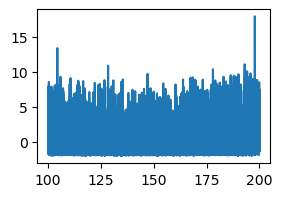

In [6]:
#signal=Experiment("./20211215_85n#4.smr").signal(0,"A")[0]
signal=Experiment("./20190129_35s_syn.smr").signal(0,"A")[0].t(100,200)
plt.plot(signal.s,rectify(signal.pA,signal.sr))

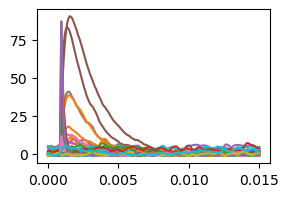

In [7]:
## fetch some "white" noise
import random
#signal=Experiment("./20211215_85n#4.smr").signal(0,"A")[0]
#s=np.concatenate([signal.t(93,101).pA,
#                  signal.t(280,290).pA,
#                  signal.t(292,298).pA,
#                  signal.t(302,318).pA])
s=Experiment("./20190129_35s_syn.smr").signal(0,"A")[0]
s=rectify(s.pA,s.sr,kind='rms')
t_psc=np.linspace(0.000,0.015,177)
cnt=1000
#amplitudes=np.random.uniform(0,80,cnt)
amplitudes=50*np.random.standard_gamma(0.8,cnt)#np.random.uniform(0,80,cnt)
tau1=np.random.uniform(0.0002,0.0005,cnt)
tau2=np.random.uniform(0.0010,0.002,cnt)
onoff=np.random.choice([True,False],cnt)
onsets=np.random.randint(0,len(s)-177,cnt)
X_fake=[]
y_fake=[]
for a,t1,t2,y,o in zip(amplitudes,tau1,tau2,onoff,onsets):
    a_psc=y*np.roll(dexp(t_psc,a,t1,t2),10)
    a_psc+=s[o:o+177]#]np.random.choice(s,177)
    X_fake.append(a_psc)
    y_fake.append(y)

amplitudes=50*np.random.standard_gamma(0.8,cnt)#np.random.uniform(0,80,cnt)
tau1=np.random.uniform(0.00002,0.00004,cnt) ## ultra sharps should be rejected
tau2=np.random.uniform(0.00010,0.0002,cnt)  ## ultra sharps
onoff=np.random.choice([True,False],cnt)
onsets=np.random.randint(0,len(s)-177,cnt)
for a,t1,t2,y,o in zip(amplitudes,tau1,tau2,onoff,onsets):
    a_psc=y*np.roll(dexp(t_psc,a,t1,t2),10)
    a_psc+=s[o:o+177]#]np.random.choice(s,177)
    X_fake.append(a_psc)
    y_fake.append(y*0)  
p = np.random.permutation(len(X_fake))
X_fake=np.array(X_fake)[p]
y_fake=np.array(y_fake)[p]
for e in X_fake[:50]:
    plt.plot(t_psc,e)

In [30]:
with h5py.File('20211215_85n#4.hdf5', 'r') as f:
    gr=list(f.keys())[0]
    X_data1=f[gr]['psc_data'][:]
    y_data1=f[gr]['psc_mask'][:]

In [45]:
with h5py.File('20211215_85n#4.hdf5', 'r') as f:
    X_data1=f[list(f.keys())[0]][:]
    y_data1=f[list(f.keys())[1]][:]
with h5py.File("20211215_85n#1.hdf5", 'r') as f:
    X_data2=f[list(f.keys())[0]][:]
    y_data2=f[list(f.keys())[1]][:]
with h5py.File("20211110_103s.hdf5", 'r') as f:
    X_data3=f[list(f.keys())[0]][:]
    y_data3=f[list(f.keys())[1]][:]

In [63]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(np.array(X_fake),
                                               np.array(y_fake),
                                               test_size=0.25)
X_train,y_train=X_data1,y_data1

In [64]:
from pyts.classification import TimeSeriesForest
clf = TimeSeriesForest(n_windows=50,random_state=43)
clf.fit(scale(X_train), y_train)

TimeSeriesForest(n_windows=50, random_state=43)

In [67]:
#X_,y_=X_test,y_test
X_,y_=X_data2,y_data2

accuracy :  74.29718875502009
false negatives :  12.650602409638553
false positives :  13.052208835341366


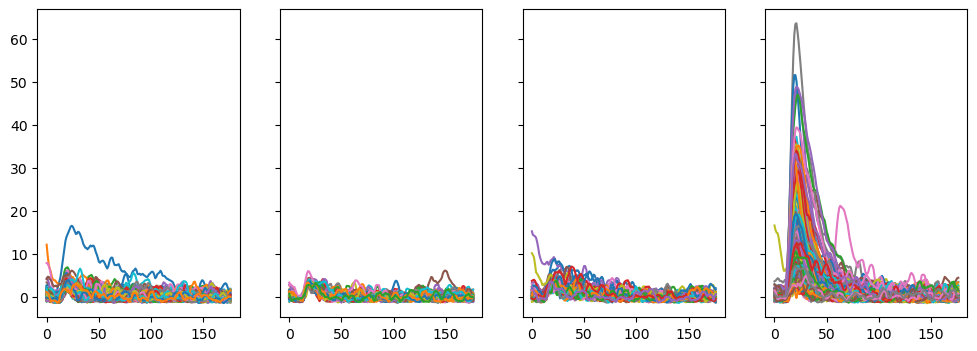

In [68]:
## do the same with real data
results=clf.predict(scale(X_))
fp=(y_==0)&(results==1)
tp=(y_==1)&(results==1)
fn=(y_==1)&(results==0)
tn=(y_==0)&(results==0)
print("accuracy : ",np.sum(results==y_)/len(results)*100)
print("false negatives : ",np.sum(fn)/len(results) *100 )
print("false positives : ",np.sum(fp)/len(results) *100 )
mpl.rcParams["figure.figsize"]=12,4
fig,axes=plt.subplots(1,4,sharey=True)
for ax,which in zip(axes,[tn,fn,fp,tp]):
    for i in X_[which]:
        ax.plot(i)

In [61]:
mpl.rcParams["figure.figsize"]=3,2.5
def show(idx):
    c='b' if results[idx]==y_[idx] else 'r'
    plt.plot(X_[idx],c=c)

ipyw.interact(show,
            idx=np.where((results==1) & (y_==0) )[0]
             )

interactive(children=(Dropdown(description='idx', options=(0, 7, 12, 14, 15, 20, 33, 35, 40, 41, 45, 49, 51, 5…

<function __main__.show(idx)>

In [69]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import homogeneity_score
from sklearn.cluster import AgglomerativeClustering

from pyts.metrics import dtw, boss
from pyts.transformation import BOSS,ROCKET

In [70]:
def create_dist_matrix(dataset, dist_func, **kwargs):
    distance_mat = np.zeros((len(dataset), len(dataset)))
    for i, j in itertools.product(range(len(dataset)),
                                  range(len(dataset))):
        distance_mat[i, j] = dist_func(dataset[i], dataset[j], **kwargs)
    return distance_mat

In [71]:
def plot_dendrogram(model, **kwargs):
    # function copied from sklearn:
    # plot_agglomerative_dendrogram.html
    #
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix,
               color_threshold=sorted(model.distances_)[-2], **kwargs)

/home/rapids/miniconda3/envs/torchpsc/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/rapids/miniconda3/envs/torchpsc/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/rapids/miniconda3/envs/torchpsc/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/rapids/miniconda3/envs/torchpsc/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


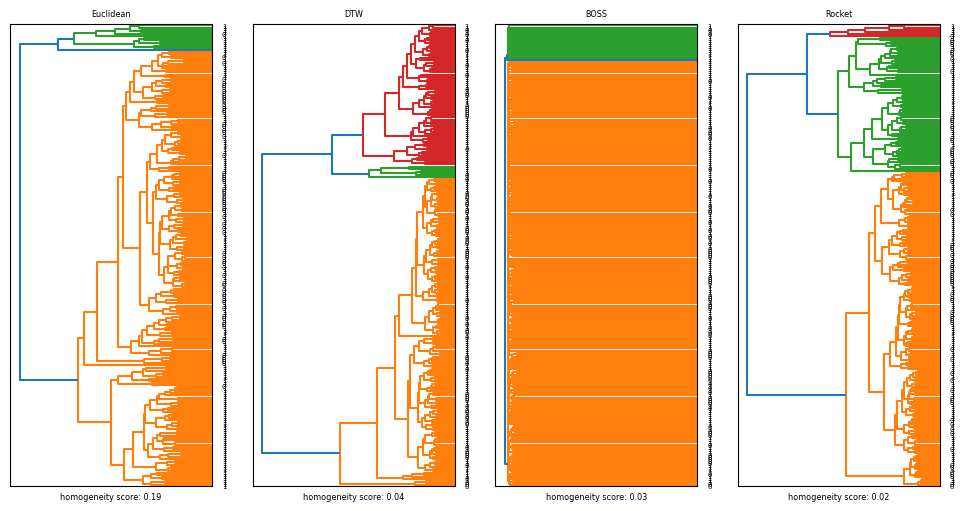

In [86]:
metrics=["Euclidean", "DTW", "BOSS","Rocket"]
nclust=5
X,y=X_data1[:,:],y_data1

fig, axes = plt.subplots(1, len(metrics), figsize=(12, 6))
clusters={}
scale=lambda X:MinMaxScaler().fit_transform(X)
#scale=lambda X:X
for k_axis, metric in enumerate(metrics):
    if metric == "DTW":
        dist_mat = create_dist_matrix(scale(X), dtw)
    elif metric == "BOSS":
        dist_mat = create_dist_matrix(BOSS(sparse=False, 
                                           n_bins=nclust,
                                           window_size=0.2,
                                           word_size=10).fit_transform(scale(X)),
                                           boss)
    elif metric=='Rocket':
        dist_mat = create_dist_matrix(ROCKET(n_kernels=10000,
                                             kernel_sizes=[15,20,25]).fit_transform(scale(X)),
                                           boss)
        
    else:
        dist_mat = create_dist_matrix(scale(X), euclidean)

    model = AgglomerativeClustering(compute_full_tree=True,
                                    compute_distances=True,
                                    n_clusters=nclust, affinity="precomputed",
                                    linkage="complete")
    cluster = model.fit_predict(dist_mat)
    score = round(homogeneity_score(labels_true=y, labels_pred=cluster), 2)
    plot_dendrogram(model, orientation='left', ax=axes[k_axis], labels=y)
    axes[k_axis].set_xticks([], [])
    axes[k_axis].set_title(metric, size='xx-small')
    axes[k_axis].set_xlabel(f"homogeneity score: {score}", size='xx-small')
    clusters[metric]=cluster

plt.show()

In [87]:
tgt='BOSS'
####
def _plot_(tgt):
    n_clusters=len(list(set(clusters[tgt])))
    mpl.rcParams["figure.figsize"]=6,4
    fig,axes=plt.subplots(n_clusters,1,sharey=True)
    for c in range(n_clusters):
        for i in X[clusters[tgt]==c]:
            axes[c].plot(i)
ipyw.interact(_plot_,tgt=metrics)

interactive(children=(Dropdown(description='tgt', options=('Euclidean', 'DTW', 'BOSS', 'Rocket'), value='Eucli…

<function __main__._plot_(tgt)>

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from pyts.classification import LearningShapelets
from pyts.datasets import load_gunpoint
from pyts.utils import windowed_view

# Load the data set and fit the classifier
#X, _, y, _ = load_gunpoint(return_X_y=True)
X_,y_=X_data1,y_data1
clf = LearningShapelets(random_state=42, tol=0.01)
clf.fit(X_, y_)

LearningShapelets(random_state=42, tol=0.01)

In [89]:
results=clf.predict(X_)
print(np.sum(results==y_)/len(y_))

0.8407079646017699


In [60]:
mpl.rcParams["figure.figsize"]=4,2
def pltshape(i):
    plt.plot(clf.shapelets_[0,i])
ipyw.interact(pltshape,
             i=range(100))

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

<function __main__.pltshape(i)>

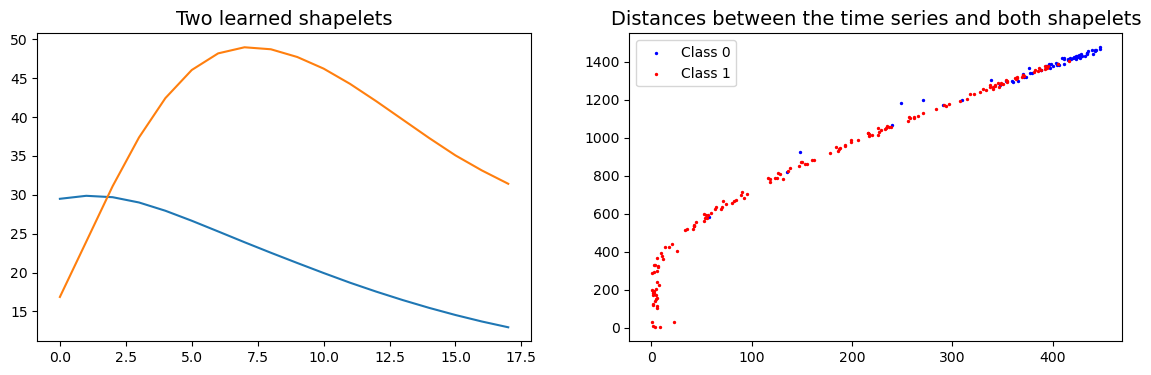

In [93]:
# Select two shapelets
shapelets = np.asarray([clf.shapelets_[0, 2], clf.shapelets_[0, 7]])

# Derive the distances between the time series and the shapelets
shapelet_size = shapelets.shape[1]
X_window = windowed_view(X_, window_size=shapelet_size, window_step=1)
X_dist = np.mean(
    (X_window[:, :, None] - shapelets[None, :]) ** 2, axis=3).min(axis=1)

plt.figure(figsize=(14, 4))

# Plot the two shapelets
plt.subplot(1, 2, 1)
plt.plot(shapelets[0])
plt.plot(shapelets[1])
plt.title('Two learned shapelets', fontsize=14)

# Plot the distances
plt.subplot(1, 2, 2)
for color, label in zip('br', (0, 1)):
    plt.scatter(X_dist[y == label, 0], X_dist[y == label, 1],
                c=color,s=2, label='Class {}'.format(label))
plt.title('Distances between the time series and both shapelets',
          fontsize=14)
plt.legend()
plt.show()

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.datasets import load_gunpoint
from pyts.transformation import ROCKET
from sklearn.feature_selection import mutual_info_classif

# Toy dataset
X_, y, = X_real,y_real

# ROCKET transformation
rocket = ROCKET(n_kernels=5000, 
                kernel_sizes=[50],
                random_state=42)
X_rocket = rocket.fit_transform(X)

# Find the most discriminative kernels
n_kernels = 4
mutual_info = mutual_info_classif(X_rocket, y, random_state=42)
indices = np.floor_divide(np.argsort(mutual_info), 2)[-n_kernels:]

# Visualize the weights of the most discriminative kernels
plt.figure(figsize=(8, 4))
for idx in indices:
    plt.plot(rocket.weights_[idx, :rocket.length_[idx]], 'o-',
             label='Kernel {}'.format(idx))
plt.legend(loc='best')
plt.title('Weights of the four most discriminative kernels \n'\
          '(criterion: mutual information)', fontsize=14)
plt.xticks([])
plt.show()


NameError: name 'X_real' is not defined